In [24]:
# get_ipython().magic('matplotlib notebook')
# get_ipython().magic('matplotlib inline')
# get_ipython().magic('load_ext autoreload')
# get_ipython().magic('autoreload 2')
%matplotlib inline
%load_ext autoreload
%autoreload 2
    
#___________________________________________________________________________________________________________________
import os
import tripyview as tpv
import shapefile as shp
import numpy     as np
import xarray    as xr
import time      as clock
import warnings
xr.set_options(keep_attrs=True)
do_parallel   = False
parallel_nprc = 48   # number of dask workers
parallel_tmem = 200  # max. available RAM

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### INFO:
To compute especially on large unstructured grids #vertices>1M, you need to run this notebook in parallel (do_parallel=True) on several workers (parallel_nprc...is the number of dask worker that can be allocated, parallel_tmem...is the maximum available RAM that will be distributed between the dask workers). Therefor allocate a full !!! COMPUTE NODE !!! (admins might not be happy if you do this in parallel on a login node) of a HPC of your choice with as much memory (RAM) as you can get to run this notebook!

In [25]:
if do_parallel:
    from dask.distributed import Client
    # from dask.diagnostics import ProgressBar
    import dask
    print(' --> memory_limit: {:3.3f} GB'.format(parallel_tmem/(parallel_nprc)))
    ## dask.config.config.get('distributed').get('dashboard').update({'link':'{JUPYTERHUB_SERVICE_PREFIX}/proxy/{port}/status'})
    client = Client(n_workers=parallel_nprc, threads_per_worker=1, memory_limit='{:3.3f} GB'.format(parallel_tmem/parallel_nprc))
    client

In [26]:
# Parameters
# mesh_path ='/work/ollie/projects/clidyn/FESOM2/meshes/core2/'
mesh_path = '/albedo/work/user/pscholz/mesh_fesom2.0/core2_srt_dep@node/'
# mesh_path = '/albedo/work/user/pscholz/mesh_fesom2.0/dart_test/'
save_path = None #'~/figures/test_papermill/'
save_fname= None

#_____________________________________________________________________________________
input_paths= list()
input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_jayne_bin_ck0.1/5/')
input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_nycander_bin_ck0.1/5/')
input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_stormtide_bin_ck0.1/5/')
input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke_ctrl_ck0.1/5/')

input_names= list()
input_names.append('TKE+IDEMIX, jayne')
input_names.append('TKE+IDEMIX, nycander')
input_names.append('TKE+IDEMIX, stormtide')
input_names.append('TKE')

# n_cycl: which spinupcycle should be plottet if do_allcycl all spinupcycles from [1...n_cycle] are plottet, if None path is directly used
n_cycl    = None
do_allcycl= True 
vname     = 'temp'
year      = [1958, 2019]
mon, day, record, box, depth = None, None, None, None, None

#_____________________________________________________________________________________
# do anomaly plots in case ref_path is not None
ref_path  = None #'/home/ollie/pscholz/results/trr181_tke_ctrl_ck0.1/' # None
ref_name  = None #'TKE, ck=0.1' # None
ref_year  = None # [2009,2019]
ref_mon, ref_day, ref_record = None, None, None

#_____________________________________________________________________________________
box_regions = list()
box_regions.append('global')
# box_regions.append('ocean_basins/Arctic_Basin.shp')
# box_regions.append('ocean_basins/Eurasian_Basin.shp')
# box_regions.append('mpas_region/Canada_Basin.shp')
# box_regions.append('mpas_region/North_Atlantic_Ocean.shp')
# box_regions.append('mpas_region/Greenland_Sea.shp')
# box_regions.append('mpas_region/Irminger_Sea.shp')
# box_regions.append('mpas_region/Norwegian_Sea.shp')
# box_regions.append('mpas_region/Labrador_Sea.shp')
# box_regions.append('mpas_region/North_Pacific_Ocean.shp')
# box_regions.append('mpas_region/South_Pacific_Ocean.shp')
# box_regions.append('mpas_region/Southern_Ocean.shp')
# box_regions.append('mpas_region/Western_Weddell_Sea.shp')

#_____________________________________________________________________________________
cstr, cnum  = 'blue2red', 15
cref, crange, cmin, cmax, cfac, climit = None, None, None, None, None, None
chist, ctresh = True, 0.995

# ref_cstr, ref_cnum = 'wbgyr', 15
# ref_cref, ref_crange, ref_cmin, ref_cmax, ref_cfac, ref_climit = None, None, None, None, None, None
# ref_chist, ref_ctresh = True, 0.995

#_____________________________________________________________________________________
ncol              = 2      # number of pannel columns in figure
plt_opt           = dict({'marker':'o'})
do_concat         = False 
do_enum           = False  # do enumeration of panels
do_shdw           = False
do_mean           = True
do_std            = False
save_dpi          = 300
save_fmt          = ['png']
which_tmean       = 'None' # 'None', 'annual', 'monthly'
which_hzmean      = 'wmean'

In [27]:
#___LOAD FESOM2 MESH___________________________________________________________________________________
mesh=tpv.load_mesh_fesom2(mesh_path, do_rot='None', focus=0, do_info=True, do_pickle=True)

#__________________________________________________________________________________________________   
if n_cycl is not None: 
    cycl_s=1 if do_allcycl else n_cycl
    aux_path, aux_name = list(), list()
    input_paths_old, input_names_old = input_paths, input_names
    for ii, (ipath,iname) in enumerate(zip(input_paths,input_names)):
        for ii_cycl in range(cycl_s, n_cycl+1):
            # input_paths[ii] = os.path.join(ipath,'{:d}/'.format(which_cycl))
            aux_path.append(os.path.join(ipath,'{:d}/'.format(ii_cycl)))
            if not do_allcycl: aux_name.append('{}'.format(iname))
            else             : aux_name.append('{:d}) {}'.format(ii_cycl, iname))
            print(ii, aux_path[-1],aux_name[-1])
    input_paths, input_names = aux_path, aux_name
    
    #__________________________________________________________________________________________________
    if (ref_path is not None): 
        aux_path, aux_name = list(), list()
        ref_path_old, ref_name_old = ref_path, ref_name
        for ii_cycl in range(cycl_s, n_cycl+1):
            #ref_path = os.path.join(ref_path,'{:d}/'.format(which_cycl))
            aux_path.append(os.path.join(ref_path,'{:d}/'.format(ii_cycl)))
            if not do_allcycl: aux_name.append('{}'.format(ref_name))
            else             : aux_name.append('{:d}) {}'.format(ii_cycl, ref_name))
            print('R', ref_path[-1])        
        ref_path, ref_name = aux_path, aux_name
    del(aux_path, aux_name)    
        
#______________________________________________________________________________________________________        
cinfo=tpv.set_cinfo(cstr, cnum, crange, cmin, cmax, cref, cfac, climit, chist, ctresh)
    
#______________________________________________________________________________________________________
# in case of diff plots
if (ref_path is not None): 
    if ref_year   is None: ref_year   = year
    if ref_mon    is None: ref_mon    = mon
    if ref_record is None: ref_record = record

#______________________________________________________________________________________________________    
# concatenate list = list1+list2
if (ref_path is not None): 
    if isinstance(ref_path, list): 
        input_paths, input_names = ref_path + input_paths        , ref_name + input_names
    else:    
        input_paths, input_names = list([ref_path]) + input_paths, list([ref_name]) + input_names        
        
#________________________________________________________________________________________________________
# define index regions --> reading shape files
box = list()
shp_path = os.path.join(tpv.__path__[0],'shapefiles/')
for region in box_regions:
    if region == 'global' or isinstance(region,list): 
        print('global')
        box.append(region)
    else: 
        print(tpv.__path__[0],region)
        box.append(shp.Reader(os.path.join(shp_path,region)))   

 > found *.pckl file: /albedo/work/user/pscholz/mesh_fesom2.0/core2_srt_dep@node
 > load  *.pckl file: tripyview_fesom2_core2_srt_dep@node_focus0.pckl
___FESOM2 MESH INFO________________________
 > path            = /albedo/work/user/pscholz/mesh_fesom2.0/core2_srt_dep@node
 > id              = core2_srt_dep@node
 > do rot          = None
 > [al,be,ga]      = 50, 15, -90
 > do augmpbnd     = True
 > do cavity       = False
 > do lsmask       = True
 > do earea,eresol = True, False
 > do narea,nresol = True, False
___________________________________________
 > #node           = 126858
 > #elem           = 244659
 > #lvls           = 48
___________________________________________
global


In [28]:
#___LOAD FESOM2 DATA___________________________________________________________________________________
data_list  = list()
for ii, (datapath, descript) in enumerate(zip(input_paths, input_names)):
    print(ii, datapath, descript)
    ts = clock.time()
    #__________________________________________________________________________________________________
    # load data and do vertical weighted mean 
    data = tpv.load_data_fesom2(mesh, datapath, vname=vname, year=year, mon=mon, descript=descript, 
                                do_tarithm=which_tmean, do_zarithm='None', do_zweight=True, do_info=False,
                                do_load=False, do_persist=True)
    #__________________________________________________________________________________________________    
    # check if data where loaded
    if data is None: raise ValueError(f'data == None, data could not be readed, your path:{datapath} might be wrong!!!')
    print(' --> elasped time to load data: {:3.2f} min.'.format( (clock.time()-ts)/60  ))        
    print(' --> data uses {:3.2f} Gb:'.format(data.nbytes/(1024**3)))

    #__________________________________________________________________________________________________
    # select horizontal index region --> do horizontal weighted mean 
    ts = clock.time()
    data = tpv.load_index_fesom2(mesh, data, box, do_harithm=which_hzmean, do_zarithm=which_hzmean)
    print(' --> elasped time to comp. index.: {:3.2f} min.'.format( (clock.time()-ts)/60  )) 
    
    #__________________________________________________________________________________________________
    # compute year mean
    if   which_tmean=='annual':
        data[0] = data[0].groupby('time.year').mean('time', keep_attrs=True)
    # compute month mon --> seasonal cycle     
    elif which_tmean=='monthly':
        data[0] = data[0].groupby('time.month').mean('time', keep_attrs=True)
    data_list.append(data)
    del(data)


0 /albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_jayne_bin_ck0.1/5/ TKE+IDEMIX, jayne
 --> elasped time to load data: 0.45 min.
 --> data uses 1.40 Gb:
 --> elasped time to comp. index.: 0.00 min.
1 /albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_nycander_bin_ck0.1/5/ TKE+IDEMIX, nycander
 --> elasped time to load data: 0.45 min.
 --> data uses 1.40 Gb:
 --> elasped time to comp. index.: 0.00 min.
2 /albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_stormtide_bin_ck0.1/5/ TKE+IDEMIX, stormtide
 --> elasped time to load data: 0.44 min.
 --> data uses 1.40 Gb:
 --> elasped time to comp. index.: 0.00 min.
3 /albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke_ctrl_ck0.1/5/ TKE
 --> elasped time to load data: 0.43 min.
 --> data uses 1.40 Gb:
 --> elasped time to comp. index.: 0.00 min.


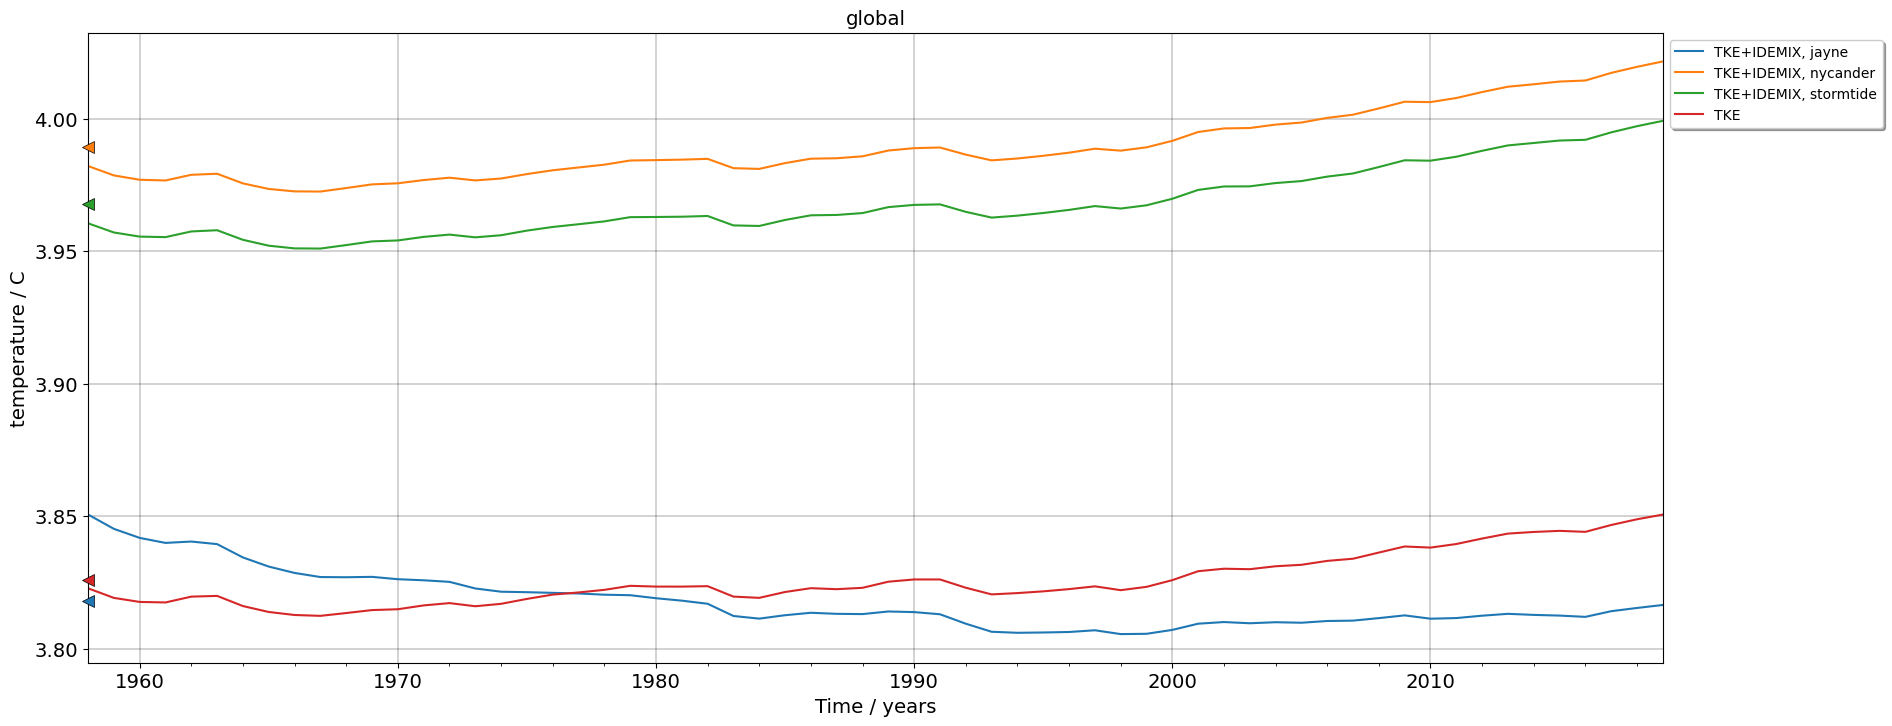

In [29]:
nbox, ndat = len(box), len(data_list)
for box_idx in range(nbox):
    
    #___PLOT TRANSECT__________________________________________________________________________________
    svname = list(data_list[0][box_idx].data_vars)[0]
    slabel = data_list[0][box_idx][svname].attrs['str_lsave']
    stname = data_list[0][box_idx][svname].attrs['boxname'].replace(' ','_').lower()
    #__________________________________________________________________________________________________
    # do save filename path
    spath  = save_path
    sfpath = None
    if spath!=None: 
        sfpath=list()
        for sfmt in save_fmt: sfpath.append( os.path.join(spath,'{:s}_{:s}_{:s}_{:s}.{:s}'.format(svname, 't', stname ,slabel, sfmt)) )

    #__________________________________________________________________________________________________
    fig,ax=tpv.plot_tline(data_list, box, nrow=1, ncol=1 , 
                            n_cycl     = n_cycl                  , 
                            do_allcycl = do_allcycl              , 
                            do_concat  = do_concat               , 
                            do_shdw    = do_shdw                 ,
                            do_mean    = do_mean                 ,
                            do_std     = do_std                  ,
                            ax_opt     = dict({'fig_sizefac':4}) ,
                            do_enum    = do_enum                 ,
                            do_save    = sfpath, save_dpi=save_dpi, 
                            )  